In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets
import torch.utils.data
import torchvision.transforms.functional as F
import matplotlib as mpl
from typing import Tuple
from PIL import Image

import transforms
import visualize

from brain_segmentation_pytorch.unet import UNet

## Dataset setup

In [2]:
classnames = {
    0: 'background',
    1: 'aeroplane',
    2: 'bicycle',
    3: 'bird',
    4: 'boat',
    5: 'bottle',
    6: 'bus',
    7: 'car',
    8: 'cat',
    9: 'chair',
    10: 'cow',
    11: 'diningtable',
    12: 'dog',
    13: 'horse',
    14: 'motorbike',
    15: 'person',
    16: 'potted plant',
    17: 'sheep',
    18: 'sofa',
    19: 'train',
    20: 'tv/monitor'
}
CLASS_MAX=20

### Transforms

In [3]:
tr_img = transforms.input_transform(transforms.PASCAL_VOC_2012_MEAN, transforms.PASCAL_VOC_2012_STD)
tr_target = transforms.target_transform(max_class=transforms.PASCAL_VOC_2012_CLASS_MAX)
tr_img_inv = transforms.inv_normalize(transforms.PASCAL_VOC_2012_MEAN, transforms.PASCAL_VOC_2012_STD)

### Dataset loading

In [4]:
dataroot = './data/'

In [5]:
ds_train = torchvision.datasets.VOCSegmentation(
    root=dataroot,
    year="2012",
    image_set="train",
    download=False,
    transform=tr_img,
    target_transform=tr_target)


In [6]:
ds_val = torchvision.datasets.VOCSegmentation(
    root=dataroot,
    year="2012",
    image_set="val",
    download=False,
    transform=tr_img,
    target_transform=tr_target)

In [7]:
len(ds_train)

1464

In [8]:
img, mask = ds_train[2]

In [9]:
img.shape

torch.Size([3, 256, 256])

In [10]:
img.device

device(type='cpu')

In [11]:
mask.shape

torch.Size([256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


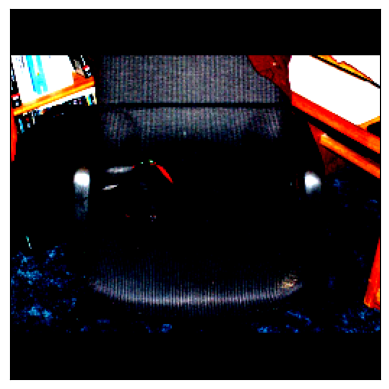

In [12]:
visualize.imshow_tensor(img)

In [13]:
ds_train = torchvision.datasets.VOCSegmentation(
    root="./data/", year="2012", image_set="train", download=False,
    transform=transforms.input_transform(transforms.PASCAL_VOC_2012_MEAN, transforms.PASCAL_VOC_2012_STD),
    target_transform=transforms.target_transform(max_class=transforms.PASCAL_VOC_2012_CLASS_MAX)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


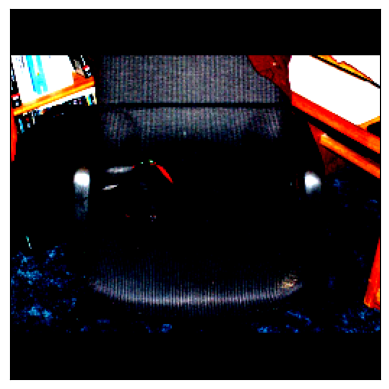

In [14]:
visualize.imshow_tensor(ds_train[2][0])

## Load Model

In [15]:
# Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
checkpointfile = "./test.chpt.pt"

In [17]:
# Model from checkpoint file
checkpoint = torch.load(checkpointfile)
unet_features = checkpoint['model_state_dict']['encoder1.enc1conv1.weight'].size(0)
model = UNet(
    in_channels=3,
    out_channels=CLASS_MAX+1,
    init_features=unet_features,
)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.eval().to(device)

In [18]:
# Model from old save
model_state_file = './dogunet_overfitted.pth'
model = torch.load(model_state_file).eval()

## Predictions

In [19]:
def topclass_dict(mask: torch.Tensor, k: int=4):
    pred_classes, counts = mask.unique(return_counts=True)
    topcounts, topcounts_idx = torch.topk(counts, min(k, len(counts)))
    #topclasses = pred_classes[topcounts_idx]

    top_k_classpixels = {
        classnames[pred_classes[i].item()] : counts[i].item()
        for i in topcounts_idx
    }

    return top_k_classpixels

In [20]:
def infer_ds_sample(sample: Tuple[torch.Tensor, torch.Tensor]):
    img, mask = sample
    img = img.unsqueeze(0)
    mask = mask.unsqueeze(0)

    with torch.no_grad():
        pred = model(img.to(device))
        pred = pred.to(device='cpu')
        pred_amax = torch.argmax(pred, dim=1)
        
        grid = visualize.make_comparison_grid(img=tr_img_inv(img), prediction=pred_amax, mask=mask)

    p = visualize.imshow_tensor(grid)
    top_k_classpixels = topclass_dict(pred_amax)


    return p, top_k_classpixels


### Training Set

(<matplotlib.image.AxesImage at 0x7f41181ca260>,
 {'background': 37637, 'chair': 20711, 'dog': 7172, 'person': 11})

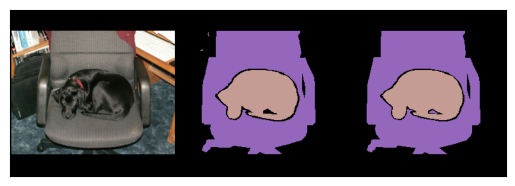

In [21]:
infer_ds_sample(ds_train[2])

(<matplotlib.image.AxesImage at 0x7f41141a0eb0>,
 {'background': 64133, 'aeroplane': 1247, 'person': 120, 'bus': 32})

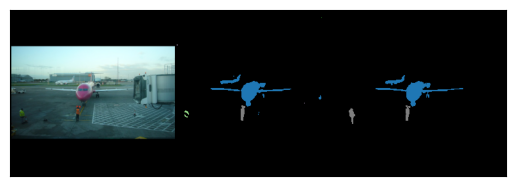

In [22]:
infer_ds_sample(ds_train[0])

### Custom Input

In [23]:
def infer_imgfile(path: str):
    with Image.open(path) as imgfile:
        img = tr_img(imgfile)

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred = pred.to(device='cpu')
        pred_amax = torch.argmax(pred.squeeze(0), dim=0)
        
        grid = visualize.make_comparison_grid(img=tr_img_inv(img.unsqueeze(0)), prediction=pred_amax.unsqueeze(0))

    p = visualize.imshow_tensor(grid)
    top_k_classpixels = topclass_dict(pred_amax)

    return p, top_k_classpixels

{'background': 58505, 'cat': 4845, 'dog': 720, 'tv/monitor': 674}

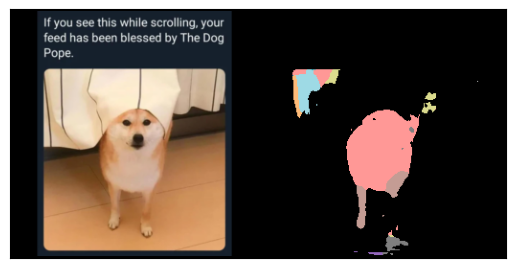

In [24]:
comp_img, classes = infer_imgfile("./data/mysamples/dogpope.jpg")
classes

{'background': 56333, 'person': 5761, 'chair': 1269, 'dog': 902}

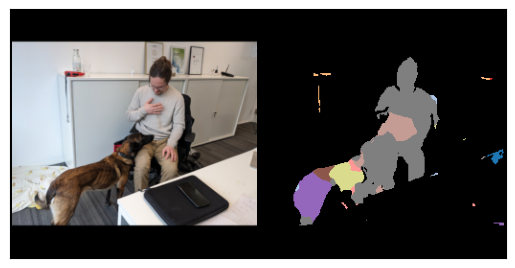

In [25]:
comp_img, classes = infer_imgfile("./data/mysamples/nelly1.jpg")
classes

{'background': 61300, 'bird': 2000, 'train': 513, 'person': 454}

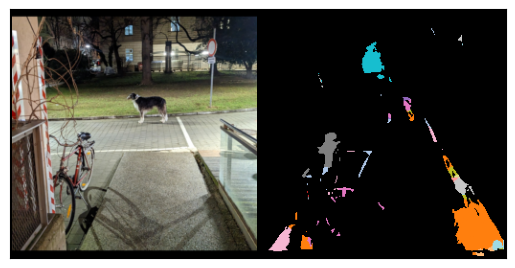

In [26]:
comp_img, classes = infer_imgfile("./data/mysamples/ghost1.jpg")
classes

{'background': 64434, 'sheep': 503, 'cow': 183, 'potted plant': 171}

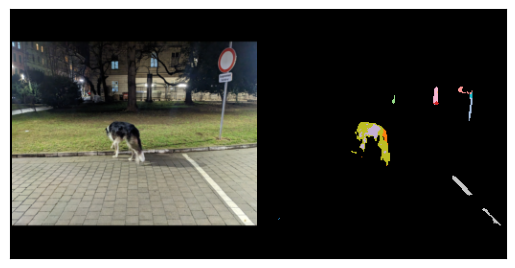

In [27]:
comp_img, classes = infer_imgfile("./data/mysamples/ghost2.jpg")
classes